In [1]:
%config IPCompleter.greedy=True

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import argparse
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from torch.autograd import Variable

import seaborn as sns

import h5py
#import pywt

## Set model parameters

In [2]:
# modelType = 'rnn'
# modelType = 'cnn'
modelType = 'rcnn'

# expDim = '1d'
expDim = '2d'

# archType = 'LSTM'
# archType = 'GRU'
# archType = 'VGG1'
# archType = 'VGG2'
# archType = 'Inception'
archType = 'RCNN'

testSplit = 'orig'
# testSplit = '7000'
# testSplit = '12000'

wavelet = False

folder_ = os.path.join('./models', modelType, expDim, archType)

results_folder = os.path.join('./results', testSplit)

if wavelet:
    results_file = 'wavelet_' + archType + '_' + expDim + '_' + testSplit + '.txt'
else:
    results_file = archType + '_' + expDim + '_' + testSplit + '.txt'

if not os.path.exists(folder_):
    os.makedirs(folder_)
    
print(folder_)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
print(results_folder)
print(results_file)

./models/rcnn/2d/RCNN
./results/orig
RCNN_2d_orig.txt


# Load Data

In [3]:
# Loads all xml files in the categorical directory
# NOTE: EXCEL COLUMN NAMES MUST BE CONSISTENT
def get_data(dir):
    df_train = pd.DataFrame()
    df_val = pd.DataFrame()
    df_test = pd.DataFrame()
    for file in os.listdir(dir):
        print(file)
        df = pd.read_excel(dir + '/' + file, usecols=[1,2,3,4,5,6,7,8])
        
        print('total:', len(df), '60%: ', len(df)*.6, '20%: ',len(df)*.2)
        
        train = int(len(df)*.6)
        val = int(train + len(df)*.2)
        test = int(val + len(df)*.2)
        df_train = df_train.append(df.iloc[:train])
        df_val = df_val.append(df.iloc[train:val])
        df_test = df_test.append(df.iloc[val:test])

    return df_train, df_val, df_test

In [ ]:
all_data = './datasets/all_data'

train_f, val_f, test_f = get_data(all_data + '/feeding')
train_r, val_r, test_r = get_data(all_data + '/resting')
train_s, val_s, test_s = get_data(all_data + '/swimming')
train_n, val_n, test_n = get_data(all_data + '/ndm')

### take the log of all data

In [ ]:
if wavelet:
    #train_f_cA, train_f_cD = pywt.dwt(train_f['ODBA'], 'db2')
    logf = np.vstack(pywt.dwt(train_f['ODBA'], 'haar')).T
    logr = np.vstack(pywt.dwt(train_r['ODBA'], 'haar')).T
    logs = np.vstack(pywt.dwt(train_s['ODBA'], 'haar')).T
    logn = np.vstack(pywt.dwt(train_n['ODBA'], 'haar')).T
    
    logvf = np.vstack(pywt.dwt(val_f['ODBA'], 'haar')).T
    logvr = np.vstack(pywt.dwt(val_r['ODBA'], 'haar')).T
    logvs = np.vstack(pywt.dwt(val_s['ODBA'], 'haar')).T
    logvn = np.vstack(pywt.dwt(val_n['ODBA'], 'haar')).T
    
    logtf = np.vstack(pywt.dwt(test_f['ODBA'], 'haar')).T
    logtr = np.vstack(pywt.dwt(test_r['ODBA'], 'haar')).T
    logts = np.vstack(pywt.dwt(test_s['ODBA'], 'haar')).T
    logtn = np.vstack(pywt.dwt(test_n['ODBA'], 'haar')).T
    
    plt.hist(train_f['ODBA'], bins='auto')
    plt.show()
    
    plt.hist(pywt.dwt(train_f['ODBA'], 'haar')[0], bins='auto')
    plt.show()
    
    plt.hist(pywt.dwt(train_f['ODBA'], 'haar')[1], bins='auto')
    plt.show()
    
    print(train_f['ODBA'])
    print(pywt.dwt(train_f['ODBA'], 'haar')[0])

elif expDim is '1d':
    logf= np.log10(train_f['ODBA'])
    logr= np.log10(train_r['ODBA'])
    logs= np.log10(train_s['ODBA'])
    logn= np.log10(train_n['ODBA'])

    logvf= np.log10(val_f['ODBA'])
    logvr= np.log10(val_r['ODBA'])
    logvs= np.log10(val_s['ODBA'])
    logvn= np.log10(val_n['ODBA'])

    logtf= np.log10(test_f['ODBA'])
    logtr= np.log10(test_r['ODBA'])
    logts= np.log10(test_s['ODBA'])
    logtn= np.log10(test_n['ODBA'])
    
    plt.hist(train_f['ODBA'], bins='auto')
    plt.show()
    
    plt.hist(logf, bins='auto')
    plt.show()

elif expDim is '2d':
    logf= train_f[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logr= train_r[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logs= train_s[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logn= train_n[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()

    logvf= val_f[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logvr= val_r[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logvs= val_s[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logvn= val_n[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()

    logtf= test_f[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logtr= test_r[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logts= test_s[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()
    logtn= test_n[['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']].dropna().to_numpy()

In [ ]:
meanf = np.mean(logf)
stdf = np.std(logf)

meanr = np.mean(logr)
stdr = np.std(logr)

means = np.mean(logs)
stds = np.std(logs)

meann = np.mean(logn)
stdn = np.std(logn)

In [ ]:
mean_ = (meanf+meanr+means+meann)/4
std_ = (stdf+stdr+stds+stdn)/4

In [ ]:
train_feed_X = (logf-mean_)/std_
train_rest_X = (logr-mean_)/std_
train_swim_X = (logs-mean_)/std_
train_ndm_X = (logn-mean_)/std_

val_feed_X = (logvf-mean_)/std_
val_rest_X = (logvr-mean_)/std_
val_swim_X = (logvs-mean_)/std_
val_ndm_X = (logvn-mean_)/std_

test_feed_X = (logtf-mean_)/std_
test_rest_X = (logtr-mean_)/std_
test_swim_X = (logts-mean_)/std_
test_ndm_X = (logtn-mean_)/std_

In [ ]:
if expDim is '2d':
    train_feed_X_nx = train_feed_X
    train_swim_X_nx = train_swim_X
    train_rest_X_nx = train_rest_X
    train_ndm_X_nx = train_ndm_X

    val_feed_X_nx = val_feed_X
    val_swim_X_nx = val_swim_X
    val_rest_X_nx = val_rest_X
    val_ndm_X_nx = val_ndm_X

    test_feed_X_nx = test_feed_X
    test_swim_X_nx = test_swim_X
    test_rest_X_nx = test_rest_X
    test_ndm_X_nx = test_ndm_X

else:
    train_feed_X_nx = np.expand_dims(train_feed_X, axis=1)
    train_swim_X_nx = np.expand_dims(train_swim_X, axis=1)
    train_rest_X_nx = np.expand_dims(train_rest_X, axis=1)
    train_ndm_X_nx = np.expand_dims(train_ndm_X, axis=1)

    val_feed_X_nx = np.expand_dims(val_feed_X, axis=1)
    val_swim_X_nx = np.expand_dims(val_swim_X, axis=1)
    val_rest_X_nx = np.expand_dims(val_rest_X, axis=1)
    val_ndm_X_nx = np.expand_dims(val_ndm_X, axis=1)

    test_feed_X_nx = np.expand_dims(test_feed_X, axis=1)
    test_swim_X_nx = np.expand_dims(test_swim_X, axis=1)
    test_rest_X_nx = np.expand_dims(test_rest_X, axis=1)
    test_ndm_X_nx = np.expand_dims(test_ndm_X, axis=1)

In [ ]:
test_feed_X_nx.shape

In [ ]:
test_swim_X_nx.shape

In [ ]:
test_rest_X_nx.shape

In [ ]:
test_ndm_X_nx.shape

# Generate Samples
* Train randomly sampled 10000 times in each category to balance data  
* Validation randomly sampled 2000 times in each category
* Test incrementally sampled    

__Classification Labels:__  
* Feeding = 0  
* Resting = 1  
* Swimming = 2
* ndm = 3

In [ ]:
# If training, then randomly sample
# If test, increment by 50 each time (sliding window non-overlapping)

#dims is set to one to only take ODBM
#for more data, expand dims

# if expDim is '2d' and modelType is 'cnn':
#     if wavelet:
#         dims = 2
#     else:
#         dims = 6
#     chan = 1
#     def gen_samples(data, n_samples, label, n_frames, train=True):
#         X = np.zeros((n_samples, chan, dims, n_frames), dtype=np.float32)
#         Y = np.full((n_samples, 1), label, dtype=np.int64)
#         print(data.shape)
#         if train:
#             for i in range(n_samples):
#                 rand = np.random.randint(low=0, high=len(data)-n_frames)
#                 for j in range(dims):
#                     X[i][0][j] = data[rand:rand+n_frames, 0, j]
#         else:
#             for i in range(n_samples):
#                 for j in range(dims):
#                     X[i][0][j] = data[i*n_frames:i*n_frames+n_frames, 0, j]
#         return X, Y
    

if wavelet:
    dims = 2
elif expDim is '1d':
    dims = 1
elif expDim is '2d':
    dims = 6


def gen_samples(data, n_samples, label, n_frames, train=True):
    X = np.zeros((n_samples, dims, n_frames), dtype=np.float32)
    Y = np.full((n_samples, 1), label, dtype=np.int64)
    if train:
        for i in range(0, n_samples):
            rand = np.random.randint(low=0, high=len(data)-n_frames)
            for j in range(0, dims):
                X[i][j] = data[rand:rand+n_frames, j]
    else:
        for i in range(0, n_samples):
            for j in range(0, dims):
                X[i][j] = data[i*n_frames:i*n_frames+n_frames, j]
        
    return X, Y

In [ ]:
(2700/50), (78315/50), (244985/50), (22200/50)

In [ ]:
# Generate 10000 train samples in each category
seed = 17
n_frames = 50
np.random.seed(seed)
samples_train = 10000
samples_val = 3000

_train_feed_X, _train_feed_Y = gen_samples(train_feed_X_nx, samples_train, 0, n_frames, train=True)
_train_rest_X, _train_rest_Y = gen_samples(train_rest_X_nx, samples_train, 1, n_frames, train=True)
_train_swim_X, _train_swim_Y = gen_samples(train_swim_X_nx, samples_train, 2, n_frames, train=True)
_train_ndm_X,  _train_ndm_Y  = gen_samples(train_ndm_X_nx, samples_train, 3, n_frames, train=True)

train_X = np.concatenate((_train_feed_X, _train_rest_X, _train_swim_X, _train_ndm_X))
train_Y = np.concatenate((_train_feed_Y, _train_rest_Y, _train_swim_Y, _train_ndm_Y))

_val_feed_X, _val_feed_Y = gen_samples(val_feed_X_nx, samples_val, 0, n_frames, train=True)
_val_rest_X, _val_rest_Y = gen_samples(val_rest_X_nx, samples_val, 1, n_frames, train=True)
_val_swim_X, _val_swim_Y = gen_samples(val_swim_X_nx, samples_val, 2, n_frames, train=True)
_val_ndm_X,  _val_ndm_Y  = gen_samples(val_ndm_X_nx, samples_val, 3, n_frames, train=True)

val_X = np.concatenate((_val_feed_X, _val_rest_X, _val_swim_X, _val_ndm_X))
val_Y = np.concatenate((_val_feed_Y, _val_rest_Y, _val_swim_Y, _val_ndm_Y))

if testSplit is 'orig':
    #number of samples generated from sliding window on 20% of data
    feed__ = 54
    rest__ = 4899
    swim__ = 1566
    ndm__ = 444
#     feed__ = 54//2
#     rest__ = 4899//2
#     swim__ = 1566//2
#     ndm__ = 444//2
        
    _test_feed_X, _test_feed_Y = gen_samples(test_feed_X_nx, feed__, 0, n_frames, train=False)
    _test_rest_X, _test_rest_Y = gen_samples(test_rest_X_nx, rest__, 1, n_frames, train=False)
    _test_swim_X, _test_swim_Y = gen_samples(test_swim_X_nx, swim__, 2, n_frames, train=False)
    _test_ndm_X,  _test_ndm_Y  = gen_samples(test_ndm_X_nx, ndm__, 3, n_frames, train=False)

elif testSplit is '7000':
    #create random samples for testing - new test nums....
    feed__ = 500
    rest__ = 4000
    swim__ = 2000
    ndm__ = 500

    _test_feed_X, _test_feed_Y = gen_samples(test_feed_X_nx, feed__, 0, n_frames, train=True)
    _test_rest_X, _test_rest_Y = gen_samples(test_rest_X_nx, rest__, 1, n_frames, train=True)
    _test_swim_X, _test_swim_Y = gen_samples(test_swim_X_nx, swim__, 2, n_frames, train=True)
    _test_ndm_X,  _test_ndm_Y  = gen_samples(test_ndm_X_nx, ndm__, 3, n_frames, train=True)

elif testSplit is '12000':
    samples_test = 3000
    
    #create random samples for testing
    _test_feed_X, _test_feed_Y = gen_samples(test_feed_X_nx, samples_test, 0, n_frames, train=True)
    _test_rest_X, _test_rest_Y = gen_samples(test_rest_X_nx, samples_test, 1, n_frames, train=True)
    _test_swim_X, _test_swim_Y = gen_samples(test_swim_X_nx, samples_test, 2, n_frames, train=True)
    _test_ndm_X,  _test_ndm_Y  = gen_samples(test_ndm_X_nx, samples_test, 3, n_frames, train=True)
    
test_X = np.concatenate((_test_feed_X, _test_rest_X, _test_swim_X, _test_ndm_X))
test_Y = np.concatenate((_test_feed_Y, _test_rest_Y, _test_swim_Y, _test_ndm_Y))

### Save/load augmented datasets

In [3]:
def write(data, outfile):
    '''
        This function writes the pre-processed image data to a HDF5 file
        Args:
          data: numpy.array, image data as numpy array
          outfile: string, path to write file to
    '''
    print("---------------------------------------")
    print("Saving data")
    print("---------------------------------------\n")
    with h5py.File(outfile, "w") as f:
        f.create_dataset("shark_data", data=data, dtype=data.dtype)

def load(infile):
    '''
        This function loads the image data from a HDF5 file 
        Args:
          outfile: string, path to read file from
          
        Returns:
          f["image"][()]: numpy.array, image data as numpy array
    '''
    print("---------------------------------------")
    print("Loading data")
    print("---------------------------------------\n")
    with h5py.File(infile, "r") as f:
        return f["shark_data"][()]

In [4]:
data_folder = os.path.join('./datasets/data', expDim)
    
if not os.path.exists(data_folder + '/' + testSplit):
    os.makedirs(data_folder + '/' + testSplit)

load_data = True

if load_data:
    train_X = load(data_folder + '/train_data.hdf5')
    train_Y = load(data_folder + '/train_gt.hdf5')
    val_X   = load(data_folder + '/val_data.hdf5')
    val_Y   = load(data_folder + '/val_gt.hdf5')
    test_X  = load(data_folder + '/' + testSplit + '/test_data.hdf5')
    test_Y  = load(data_folder + '/' + testSplit + '/test_gt.hdf5')

else:
    write(train_X, data_folder + '/train_data.hdf5')
    write(train_Y, data_folder + '/train_gt.hdf5')
    write(val_X,   data_folder + '/val_data.hdf5')
    write(val_Y, data_folder + '/val_gt.hdf5')
    write(test_X, data_folder + '/' + testSplit + '/test_data.hdf5')
    write(test_Y, data_folder + '/' + testSplit + '/test_gt.hdf5')

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------

---------------------------------------
Loading data
---------------------------------------



In [5]:
print(data_folder)

./data/2d


In [6]:
cnn = (modelType is 'cnn') or (modelType is 'rcnn')

if cnn and expDim is '2d':
    train_X = np.expand_dims(train_X, axis=1)
    val_X = np.expand_dims(val_X, axis=1)
    test_X = np.expand_dims(test_X, axis=1)

In [7]:
print(train_X[333])
print(val_X[123])
print(train_Y[444])
print(val_Y[321])

[[[-0.7239724  -0.71932805 -0.71587414 -0.71388334 -0.7116249
   -0.7102969  -0.7088363  -0.70910144 -0.71016437 -0.712823
   -0.7149463  -0.71481377 -0.71388334 -0.7150763  -0.7129504
   -0.7125528  -0.712823   -0.7142836  -0.71680456 -0.7189304
   -0.7210537  -0.72291195 -0.72477275 -0.72623336 -0.72716117
   -0.7282216  -0.7291494  -0.73007727 -0.7319355  -0.7299447
   -0.72981215 -0.73220056 -0.74056643 -0.74720407 -0.7550347
   -0.76313287 -0.770966   -0.7790668  -0.7879603  -0.79712397
   -0.80548733 -0.81504864 -0.8264682  -0.8378878  -0.84903723
   -0.86085445 -0.8729368  -0.88329345 -0.8929873  -0.9020134 ]
  [ 2.343749    2.3450747   2.3445444   2.3429513   2.3406928
    2.3404276   2.3404276   2.3405602   2.3408253   2.3414881
    2.3418858   2.341223    2.3372414   2.3360484   2.3332598
    2.3327296   2.3329947   2.3331273   2.3331273   2.332197
    2.3307364   2.329671    2.328873    2.3282104   2.3272824
    2.3260894   2.324764    2.3237035   2.3229084   2.3209176
    2

#### Check the data dimensions

In [8]:
# Check?
print(_train_feed_X.shape, _train_ndm_X.shape, _train_rest_X.shape, _train_swim_X.shape)
print(_train_feed_Y.shape, _train_ndm_Y.shape, _train_rest_Y.shape, _train_swim_Y.shape)
print(_train_feed_Y[5000], _train_ndm_Y[5000], _train_rest_Y[5000], _train_swim_Y[5000])

NameError: name '_train_feed_X' is not defined

In [9]:
val_X.shape, val_Y.shape

((12000, 1, 6, 50), (12000, 1))

In [10]:
test_X.shape, test_Y.shape

((6963, 1, 6, 50), (6963, 1))

In [11]:
train_X.shape, val_X.shape, test_X.shape

((40000, 1, 6, 50), (12000, 1, 6, 50), (6963, 1, 6, 50))

# Network

In [12]:
class SharkBehaviorDataset(Dataset):
    def __init__(self, data, labels=None, train=True):
        self.data = data
        self.train = train
        if self.train:
            self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = None
        if self.train:
            sample_label = self.labels[idx]
            return (sample, sample_label)
        return sample

In [13]:
train_X.shape, test_X.shape

((40000, 1, 6, 50), (6963, 1, 6, 50))

In [14]:
train_dataset = SharkBehaviorDataset(train_X, labels=train_Y, train=True)
val_dataset = SharkBehaviorDataset(val_X, labels=val_Y, train=True)
test_dataset = SharkBehaviorDataset(test_X, labels=test_Y, train=True)

batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)


In [15]:
%reload_ext autoreload
from networks.cnn import SharkVGG1, SharkVGG2, Sharkception
from networks.rnn import SharkLSTM, SharkGRU

from networks.cnn2d import Shark2dVGG1, Shark2dVGG2, Sharkception2d 

from networks.rcnn import SharkRCNN2d

## SET PARAMS

In [16]:
if modelType is 'cnn':
    if expDim is '1d':
        if archType is 'VGG1':
            model = SharkVGG1(1)
        elif archType is 'VGG2':
            model = SharkVGG2(1)
        elif archType is 'Inception':
            model = Sharkception(1)
    
    elif expDim is '2d':
        if archType is 'VGG1':
            model = Shark2dVGG1(1)
        elif archType is 'VGG2':
            model = Shark2dVGG2(1)
        elif archType is 'Inception':
            model = Sharkception2d(1)
            
    model.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=.0)#, momentum=.9, nesterov=True)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=.99, nesterov=True)
    sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10000], gamma=0.1)
    
elif modelType is 'rnn':
    hidden_size = 128
    dat_size = 50
    out_size = 4
    
    num_layers = 5
    
    if archType is 'LSTM':
        model = SharkLSTM(dat_size, 
                          hidden_size, 
                          out_size, 
                          num_layers=num_layers)
        
    elif archType is 'GRU':
        model = SharkGRU(dat_size, 
                         hidden_size, 
                         out_size, 
                         num_layers=num_layers)
        
    model.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.99, nesterov=True)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10000,20000], gamma=0.1)
    
if modelType is 'rcnn':
    if expDim is '1d':
        model = SharkRCNN(1, 4)
    
    elif expDim is '2d':
        model = SharkRCNN2d(1, 4)
            
    model.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=.0)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=.99, nesterov=True)
    sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10000], gamma=0.1)

In [17]:
model

SharkRCNN2d(
  (rcl1): RecurrentConvolutionalLayer(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (lrn): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (rcl2): RecurrentConvolutionalLayer(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (lrn): LocalResponseNorm(2, alpha=0.0001, b

In [18]:
def accuracy(out, labels):
    _, pred = torch.max(out,1)
    correct = (pred == labels).sum().item()
    acc = 100*correct/len(labels)
    return acc

# Train

In [ ]:
mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []
minLoss = 99999
maxValacc = -99999
for epoch in range(500):
    print('EPOCH: ',epoch+1)
    train_acc = []
    val_acc = []
    
    running_loss = 0.0
    
    model.train()
    count = 0
    for images, labels in train_loader:
        labels = labels.squeeze()
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        
        train_acc.append(accuracy(outputs, labels))
        
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        count +=1
        
    sched.step()
    print('Training loss:.......', running_loss/count)
    mean_train_losses.append(running_loss/count)
        
    model.eval()
    count = 0
    val_running_loss = 0.0
    for images, labels in val_loader:
        labels = labels.squeeze()
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        accuracy(outputs, labels)
        
        
        loss = criterion(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        count +=1

    mean_val_loss = val_running_loss/count
    print('Validation loss:.....', mean_val_loss)
    
    print('Training accuracy:...', np.mean(train_acc))
    print('Validation accuracy..', np.mean(val_acc))
    
    mean_val_losses.append(mean_val_loss)
    
    mean_train_acc.append(np.mean(train_acc))
    
    val_acc_ = np.mean(val_acc)
    mean_val_acc.append(val_acc_)
    
    if mean_val_loss < minLoss:
        torch.save(model.state_dict(), './'+folder_+'/_loss.pth' )
        print(f'NEW BEST LOSS_: {mean_val_loss} ........old best:{minLoss}')
        minLoss = mean_val_loss
        print('')
        
    if val_acc_ > maxValacc:
        torch.save(model.state_dict(), './'+folder_+'/_acc.pth' )
        print(f'NEW BEST ACC_: {val_acc_} ........old best:{maxValacc}')
        maxValacc = val_acc_
        
    if epoch%500 == 0 :
        torch.save(model.state_dict(), './'+folder_+'/save_'+str(epoch)+'.pth' )
        print(f'DIV 200: Val_acc: {val_acc_} ..Val_loss:{mean_val_loss}')
        
    torch.save(model.state_dict(), './'+folder_+'/_last.pth' )

EPOCH:  1
Training loss:....... 0.9108531501642458
Validation loss:..... 1.8269794393093028
Training accuracy:... 60.2109872611465
Validation accuracy.. 41.989219224924014
NEW BEST LOSS_: 1.8269794393093028 ........old best:99999

NEW BEST ACC_: 41.989219224924014 ........old best:-99999
DIV 200: Val_acc: 41.989219224924014 ..Val_loss:1.8269794393093028
EPOCH:  2
Training loss:....... 0.7633710849057337
Validation loss:..... 1.6326521787237613
Training accuracy:... 66.20720541401273
Validation accuracy.. 46.74320858662614
NEW BEST LOSS_: 1.6326521787237613 ........old best:1.8269794393093028

NEW BEST ACC_: 46.74320858662614 ........old best:41.989219224924014
EPOCH:  3
Training loss:....... 0.6560264920732778
Validation loss:..... 1.0702460370165237
Training accuracy:... 69.98656449044586
Validation accuracy.. 58.480955547112465
NEW BEST LOSS_: 1.0702460370165237 ........old best:1.6326521787237613

NEW BEST ACC_: 58.480955547112465 ........old best:46.74320858662614
EPOCH:  4
Trainin

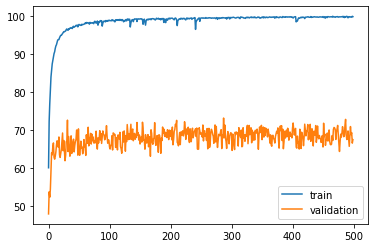

In [28]:
train_acc_series = pd.Series(mean_train_acc)
val_acc_series = pd.Series(mean_val_acc)
train_acc_series.plot(label="train")
val_acc_series.plot(label="validation")
plt.legend()

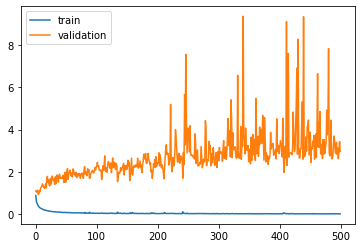

In [29]:
train_acc_series = pd.Series(mean_train_losses)
val_acc_series = pd.Series(mean_val_losses)
train_acc_series.plot(label="train")
val_acc_series.plot(label="validation")
plt.legend()

# Test

### Load model and weights

In [31]:
if modelType is 'cnn':
    if expDim is '1d':
        if archType is 'VGG1':
            model = SharkVGG1(1)
        elif archType is 'VGG2':
            model = SharkVGG2(1)
        elif archType is 'Inception':
            model = Sharkception(1)
    
    elif expDim is '2d':
        if archType is 'VGG1':
            model = Shark2dVGG1(1)
        elif archType is 'VGG2':
            model = Shark2dVGG2(1)
        elif archType is 'Inception':
            model = Sharkception2d(1)
            
elif modelType is 'rnn':
    hidden_size = 128
    dat_size = 50
    out_size = 4
    
    if archType is 'LSTM':
        model = SharkLSTM(dat_size, hidden_size, out_size)
    elif archType is 'GRU':
        model = SharkGRU(dat_size, hidden_size, out_size)
        
elif modelType is 'rcnn':
    
    if expDim is '1d':
        model = SharkRCNN(1, 4)
    
    elif expDim is '2d':
        model = SharkRCNN2d(1, 4)

model.cuda()

state_dict = torch.load('./'+ folder_ + '/_acc.pth')
# state_dict = torch.load('exp/'+ folder_ +'/_loss.pth')
# state_dict = torch.load('exp/'+ folder_ +'/_last.pth')
# state_dict = torch.load('exp/'+ folder_ +'/save_1000.pth') #0,200...
model.load_state_dict(state_dict)
model.eval()

SharkRCNN2d(
  (rcl1): RecurrentConvolutionalLayer(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (lrn): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (rcl2): RecurrentConvolutionalLayer(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (rcl2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (lrn): LocalResponseNorm(2, alpha=0.0001, b

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [33]:
preds = []
ys = []
probs = np.empty((test_X.shape[0],4))
correct = 0

with torch.no_grad():
    model.eval
    count = 0
#     preds = []
#     ys = []
    val_running_loss = 0.0
    for images, labels in test_loader:
#         tots +=1
        labels = labels.squeeze()
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        prob = nn.Softmax()(outputs).cpu().numpy()
        
        _, pred = torch.max(outputs,1)
        ys = np.concatenate([ys, labels.cpu().numpy()])
        preds = np.concatenate([preds, pred.cpu().numpy()])
        
        #probs.append(prob.tolist())
        #print(prob.shape)
        probs = np.vstack([probs, prob])
   

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
# Accuracy --8000
print('Accuracy: ', (ys == preds).sum() / ys.shape[0])

Accuracy:  0.6208530805687204


In [35]:
cm = confusion_matrix(ys, preds, [0,1,2,3])
print(cm)

[[  22    1    5   26]
 [  48 2537   97 2217]
 [   5   16 1442  103]
 [  23   61   38  322]]


/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [36]:
print(classification_report(ys, preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.2245    0.4074    0.2895        54
         1.0     0.9702    0.5179    0.6753      4899
         2.0     0.9115    0.9208    0.9161      1566
         3.0     0.1207    0.7252    0.2069       444

    accuracy                         0.6209      6963
   macro avg     0.5567    0.6428    0.5220      6963
weighted avg     0.8970    0.6209    0.6966      6963



In [37]:
minLoss, maxValacc

(0.9217876069089199, 73.14898366261399)

In [39]:
#print(probs)
probs1 = probs[test_X.shape[0]:]

print(test_X.shape[0])
print(probs1.shape)

print(metrics.roc_auc_score(ys, probs1, multi_class='ovo', labels=[0,1,2,3]))

6963
(6963, 4)
0.8423171676197737


In [40]:
with open(os.path.join(results_folder, results_file), 'w+') as f:
    f.write("Test accuracy\n")
    f.write("----------------------------------\n")
    f.write(str((ys == preds).sum() / ys.shape[0]))
    f.write('\n\n')
    f.write("Confusion matrix\n")
    f.write("----------------------------------\n")
    f.write(str(confusion_matrix(ys, preds, [0,1,2,3])))
    f.write('\n\n')
    f.write("Classification report\n")
    f.write("----------------------------------\n")
    f.write(str(classification_report(ys, preds, digits=4)))
    f.write('\n\n')
    f.write("AUC ROC\n")
    f.write("----------------------------------\n")
    f.write(str(metrics.roc_auc_score(ys, probs1, multi_class='ovo', labels=[0,1,2,3])))

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
